# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tqdm import tqdm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


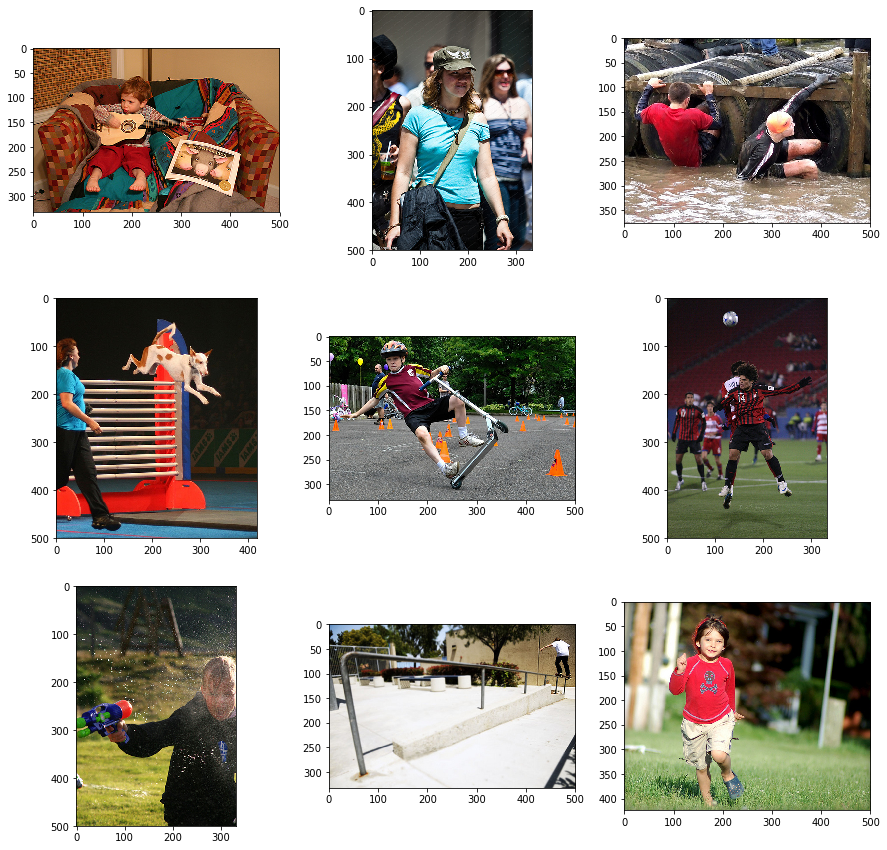

In [3]:
#Visualise the images present in the dataset
#plotting first few images
#importing library to visualise

import matplotlib.image as mpimg

plt.figure(figsize=(15, 15)) 

for i in range(9):
    #define subplot
    # pos should be a 3 digit integer and the index position starts at 1
    plt.subplot( 330 + 1 + i)
    plt.imshow(mpimg.imread(all_imgs[i]))
    
plt.show()


In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    with open(filename,'r') as f: # 'r' for opening text file and only reading
        text = list(filter(None,(sentence.rstrip() for sentence in f))) #storing the file in a list format
        f.close()
        text_list=[]
    for line in text:
        text_list.append(line.split(",",maxsplit=1)) #Maxsplit=1 used to split the image and caption into a list item
        #and commas within the sentence won't split up into separate items

    return text_list
    
doc = load_doc('Flickr8K/captions.txt')
print(doc[:300])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .'], ['1001773457_577c3a7d70.jpg', 'Two dogs on pavement moving toward each other .'], ['1002674143_1b742ab4b8.jpg', 'A little girl covere

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
img_path = 'Flickr8K/Images/'
all_img_id=[doc[i][0] for i in range(len(doc))] #store all the image id here
all_img_vector= [img_path+doc[i][0] for i in range(len(doc))]#store all the image path here
annotations= [doc[i][1] for i in range(len(doc))] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,image,Flickr8K/Images/image,caption
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...


In [6]:
# deleting the first row
df = df[1:]
df

,ID,Path,Captions
1,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
6,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
7,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
8,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
9,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
10,1001773457_577c3a7d70.jpg,Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


The above dataframe has 40455 samples 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 1 to 40455
Data columns (total 3 columns):
ID          40455 non-null object
Path        40455 non-null object
Captions    40455 non-null object
dtypes: object(3)
memory usage: 948.3+ KB


In [8]:
df['Captions'].values

array(['A child in a pink dress is climbing up a set of stairs in an entry way .',
       'A girl going into a wooden building .',
       'A little girl climbing into a wooden playhouse .', ...,
       'A person in a red shirt climbing up a rock face covered in assist handles .',
       'A rock climber in a red shirt .',
       'A rock climber practices on a rock climbing wall .'], dtype=object)

In [9]:
#Create the vocabulary & the counter for the captions
from collections import Counter
vocabulary= [] #write your code here
for i in df['Captions'].values :
    vocabulary.extend(i.split())

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [10]:
#list of all the words in the captions
vocabulary

['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '.',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '.',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '.',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 '.',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'Two'

In [11]:
#total number of unique words in vocabulary
len(val_count)

9862

In [12]:
#Visualise the top 30 occuring words in the captions
val_count.most_common(30)


[('a', 40271),
 ('.', 34212),
 ('A', 21481),
 ('in', 18961),
 ('the', 15328),
 ('on', 10729),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7982),
 ('with', 7760),
 ('man', 6828),
 ('of', 6712),
 ('Two', 3962),
 ('white', 3875),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 ('woman', 3227),
 ('girl', 3217),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('The', 2920),
 ('at', 2904),
 ('water', 2774),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2442),
 ('young', 2431),
 ('."', 2365)]

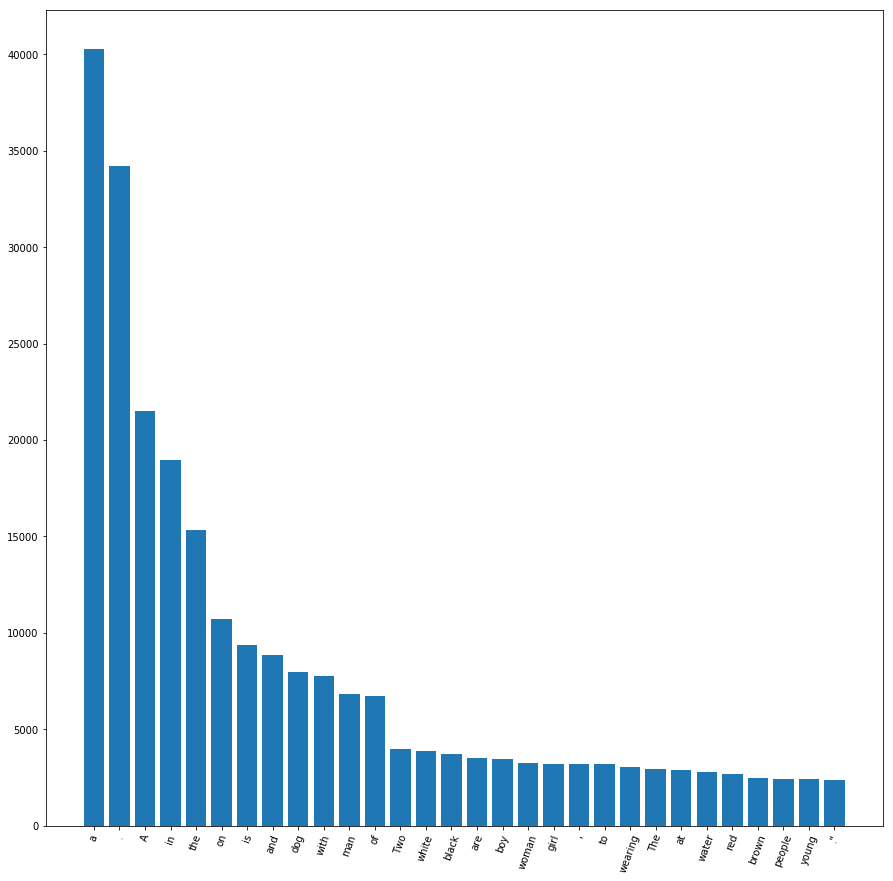

In [13]:
#the above list of tuples visualised
x = val_count.most_common(30)
plt.figure(figsize = [15,15])
plt.bar(range(len(x)), [i[1] for i in x], align='center')
plt.xticks(range(len(x)), [j[0] for j in x])
plt.xticks(rotation=70)
plt.show()


In [14]:
#Create a list which contains all the captions
annotations=[]#write your code here

#add the <start> & <end> token to all those captions as well
for i in df['Captions'].values :
    i = '<start> ' + i + ' <end>'
    annotations.append(i)

#Create a list which contains all the path to the images
all_img_path= df['Path'].tolist()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [15]:
#checking the token addition
annotations

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
 '<start> Two dogs of different breeds looking at each other on the road . <end>',
 '<start> Two dogs on pavement moving toward each other . <end>',
 '<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . <end>',
 '<start> A little girl is sitting in front of a large painted rainbow . <end>',
 '<start> A small girl in the grass plays 

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [16]:
# create the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 5000, 
                                                  filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', 
                                                  oov_token = '<UNK>')
                                                 

#fit the tokenizer on the annotations
tokenizer.fit_on_texts(annotations)

#summarize what is learnt
print(tokenizer.word_counts)#A dictionary of words and their counts
print(tokenizer.word_index)#A dictionary of words and their uniquely assigned integers

OrderedDict([('<start>', 40455), ('a', 62992), ('child', 1545), ('in', 18986), ('pink', 739), ('dress', 348), ('is', 9345), ('climbing', 507), ('up', 1302), ('set', 109), ('of', 6723), ('stairs', 109), ('an', 2432), ('entry', 1), ('way', 53), ('<end>', 40455), ('girl', 3328), ('going', 149), ('into', 1074), ('wooden', 284), ('building', 510), ('little', 1768), ('playhouse', 6), ('the', 18419), ('to', 3176), ('her', 1178), ('cabin', 4), ('black', 3848), ('dog', 8138), ('and', 8862), ('spotted', 38), ('are', 3504), ('fighting', 133), ('tri', 14), ('colored', 221), ('playing', 2008), ('with', 7765), ('each', 430), ('other', 773), ('on', 10745), ('road', 398), ('white', 3959), ('brown', 2578), ('spots', 29), ('staring', 57), ('at', 2915), ('street', 944), ('two', 5642), ('dogs', 2125), ('different', 46), ('breeds', 5), ('looking', 743), ('pavement', 48), ('moving', 41), ('toward', 146), ('covered', 372), ('paint', 62), ('sits', 577), ('front', 1386), ('painted', 64), ('rainbow', 22), ('han

In [17]:
# Create word-to-index and index-to-word mappings.

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

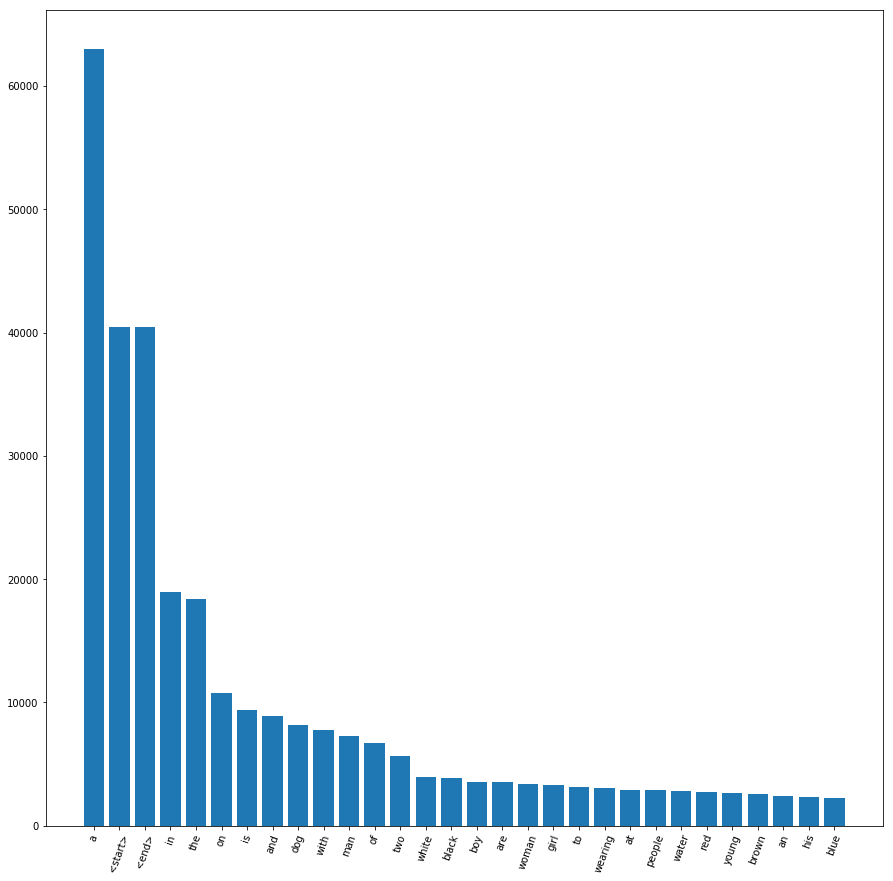

In [18]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

ordered_text = sorted(tokenizer.word_counts.items(),key = lambda x : x[1], reverse = True)
top_30 = ordered_text[0:30]
plt.figure(figsize = [15,15])
plt.bar(range(len(top_30)), [i[1] for i in top_30], align='center')
plt.xticks(range(len(top_30)), [j[0] for j in top_30])
plt.xticks(rotation=70)
plt.show()


In [19]:
#Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(annotations)
train_sequences[0:5]


[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [20]:
# maximum training sequence length
maximum_length = max([len(t) for t in train_sequences])
maximum_length

39

In [21]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = maximum_length, padding = 'post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [22]:
#looking at caption vector
cap_vector

array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

In [23]:
len(all_img_vector)

40456

In [24]:
all_img_vector = all_img_vector[1:]
len(all_img_vector)

40455

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [25]:
#creating a function to resize the image for th input pipeline for InceptionV3 model
def processed_image(image_path):
    #all transformations of the image path stored in variable img
    img = tf.io.read_file(image_path)#TensorFlow I/O is a collection of file systems and file formats 
    #that are not available in TensorFlow's built-in support
    img = tf.image.decode_jpeg(img, channels=3 )#Decode a JPEG-encoded image to a uint8 tensor
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)#scaling input pixels between -1 and 1.
    
    return img, image_path

#this function will return a dataset of transformed images and their paths upon inputting path of original image

Path of the image  Flickr8K/Images/1003163366_44323f5815.jpg


W0809 07:21:22.108391 139648692590400 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize (299, 299, 3)


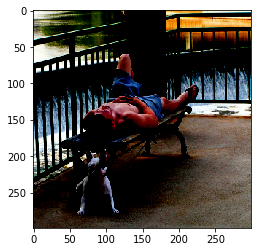

In [26]:
#testing the created function

print("Path of the image ",(all_img_vector[17]))
print("Shape after resize",processed_image(all_img_vector[17])[0].shape)
plt.imshow(processed_image(all_img_vector[17])[0])


In [27]:
#applying the image preprocessing function to the image dataset

#fastest way to get a unique list of images
all_imgs_unique = sorted(set(all_img_vector))

img_dataset = tf.data.Dataset.from_tensor_slices(all_imgs_unique)

# using from_tensor_slices emits one data at a time treating each element of input tensor as a slice

img_dataset = img_dataset.map(processed_image, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(32)

#tf.data.experimental.AUTOTUNE to tune what level of parallelism to use dynamically at runtime through an optimization algorithm
img_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [28]:
print("No. of images",len(all_imgs_unique))

No. of images 8091


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [29]:
# performing train test split
train_image, test_image, train_cap, test_cap = train_test_split(all_img_vector,cap_vector,test_size = 0.2, 
                                                                random_state = 42)

In [30]:
# check number of samples in each set
len(train_image), len(test_image), len(train_cap),len(test_cap)

(32364, 8091, 32364, 8091)

In [31]:
sample_img_batch, sample_cap_batch = next(iter(img_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 299, 299, 3)
(32,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [32]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [33]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [34]:
# write your code to extract features from each image in the dataset
for img, path in img_dataset:
    batch_features = image_features_extract_model(img)#using inceptionv3 model to extract features
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))#using -1 to infer the shape
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [35]:
#creating a map function which connects the image feature to captions
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [36]:
def generator_dataset(images, captions, batch_size = 32,Buffer_size = 1000):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(Buffer_size)
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE )#parallel calls to reduce the time
    #experimental autotune uses an optimization algorithm in the moment to determine the values
    
    return dataset
    


In [37]:
train_dataset = generator_dataset(train_image, train_cap)
test_dataset = generator_dataset(test_image, test_cap)

In [38]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 64, 2048), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 1.536537  ],
         [0.1560373 , 0.        , 0.5616193 , ..., 0.        ,
          0.        , 1.5539492 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9064581 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.26167384, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.600274  , 0.        , ..., 0.        ,
          0.32699203, 0.        ]],
 
        [[0.09669587, 0.        , 0.        , ..., 0.34480953,
          0.83363724, 0.2652215 ],
         [0.        , 0.        , 0.        , ..., 0.39963782,
          0.37125236, 0.09740348],
         [0.        , 0.        , 0.        , ..., 0.07752611,
          0.        , 0.        ],
         ...,
         [0.04502169, 0.      

In [39]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [40]:
#adding the padding in the word token index
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [41]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(train_image) // BATCH_SIZE
test_num_steps = len(test_image) // BATCH_SIZE
features_shape = bf.shape[1]

attention_features_shape = bf.shape[0]


### Encoder

In [42]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [43]:
encoder=Encoder(embedding_dim)

### Attention model

In [44]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score),axis = 1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights*features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis = 1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [45]:

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim, mask_zero =False)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector,1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [46]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [47]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [48]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction ='none') #define your loss object

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [52]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [53]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [54]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

In [55]:
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.192, & test loss is 1.011
Time taken for 1 epoch 257.4900472164154 sec

Test loss has been reduced from 100.000 to 1.011


 13%|█▎        | 2/15 [06:34<47:59, 221.48s/it]  

For epoch: 2, the train loss is 0.937, & test loss is 0.896
Time taken for 1 epoch 136.61337280273438 sec

Test loss has been reduced from 1.011 to 0.896


 20%|██        | 3/15 [08:50<39:10, 195.90s/it]

For epoch: 3, the train loss is 0.851, & test loss is 0.826
Time taken for 1 epoch 136.08664989471436 sec

Test loss has been reduced from 0.896 to 0.826


 27%|██▋       | 4/15 [11:07<32:38, 178.04s/it]

For epoch: 4, the train loss is 0.792, & test loss is 0.772
Time taken for 1 epoch 136.26040744781494 sec

Test loss has been reduced from 0.826 to 0.772


 33%|███▎      | 5/15 [13:23<27:34, 165.48s/it]

For epoch: 5, the train loss is 0.743, & test loss is 0.726
Time taken for 1 epoch 136.05703783035278 sec

Test loss has been reduced from 0.772 to 0.726


 40%|████      | 6/15 [15:39<23:30, 156.75s/it]

For epoch: 6, the train loss is 0.700, & test loss is 0.684
Time taken for 1 epoch 136.25470423698425 sec

Test loss has been reduced from 0.726 to 0.684


 47%|████▋     | 7/15 [17:55<20:04, 150.52s/it]

For epoch: 7, the train loss is 0.660, & test loss is 0.648
Time taken for 1 epoch 135.85499596595764 sec

Test loss has been reduced from 0.684 to 0.648


 53%|█████▎    | 8/15 [20:11<17:03, 146.21s/it]

For epoch: 8, the train loss is 0.625, & test loss is 0.614
Time taken for 1 epoch 136.0409255027771 sec

Test loss has been reduced from 0.648 to 0.614


 60%|██████    | 9/15 [22:27<14:19, 143.17s/it]

For epoch: 9, the train loss is 0.592, & test loss is 0.583
Time taken for 1 epoch 135.94509100914001 sec

Test loss has been reduced from 0.614 to 0.583


 67%|██████▋   | 10/15 [24:44<11:45, 141.11s/it]

For epoch: 10, the train loss is 0.561, & test loss is 0.553
Time taken for 1 epoch 136.1676504611969 sec

Test loss has been reduced from 0.583 to 0.553


 73%|███████▎  | 11/15 [27:00<09:18, 139.72s/it]

For epoch: 11, the train loss is 0.533, & test loss is 0.527
Time taken for 1 epoch 136.34793281555176 sec

Test loss has been reduced from 0.553 to 0.527


 80%|████████  | 12/15 [29:16<06:55, 138.66s/it]

For epoch: 12, the train loss is 0.508, & test loss is 0.502
Time taken for 1 epoch 136.060049533844 sec

Test loss has been reduced from 0.527 to 0.502


 87%|████████▋ | 13/15 [31:33<04:36, 138.03s/it]

For epoch: 13, the train loss is 0.485, & test loss is 0.481
Time taken for 1 epoch 136.44496655464172 sec

Test loss has been reduced from 0.502 to 0.481


 93%|█████████▎| 14/15 [33:50<02:17, 137.65s/it]

For epoch: 14, the train loss is 0.465, & test loss is 0.460
Time taken for 1 epoch 136.6153485774994 sec

Test loss has been reduced from 0.481 to 0.460


100%|██████████| 15/15 [36:06<00:00, 137.36s/it]

For epoch: 15, the train loss is 0.445, & test loss is 0.441
Time taken for 1 epoch 136.5560417175293 sec

Test loss has been reduced from 0.460 to 0.441


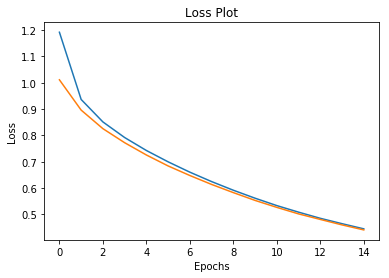

In [56]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

Loss decreases with rising number of epochs.


## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [68]:
max_length =39

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(processed_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val =image_features_extract_model(temp_input)
 # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions,1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])


        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [74]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(processed_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [75]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [76]:
from nltk.translate.bleu_score import sentence_bleu

In [77]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [130]:
pip install gTTS #installing required text to speech library


Note: you may need to restart the kernel to use updated packages.


In [131]:
from gtts import gTTS #importing required library
from IPython import display

6058
BLEU score: 59.116026033141566
Real Caption: brown black and white dog standing on a sandy slope
Prediction Caption: a brown black dog standing on a sandy slope


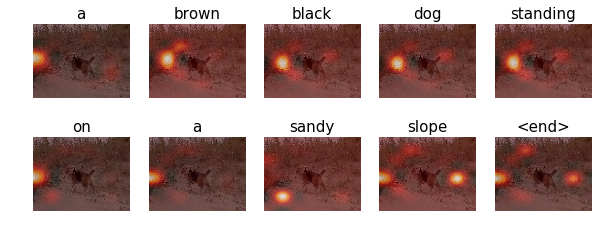

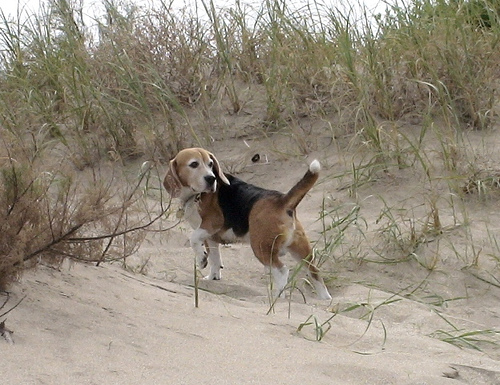

In [128]:
import warnings
warnings.filterwarnings("ignore")

rid = np.random.randint(0, len(test_image))
print(rid)
test_img = test_image[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in test_cap[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_img)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_img)


Image.open(test_img)

In [132]:
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))

2530
BLEU score: 1.3483065280626045e-229
Real Caption: car racing on a dirt road
Prediction Caption: a racing rally car raises cloud of smoke behind it


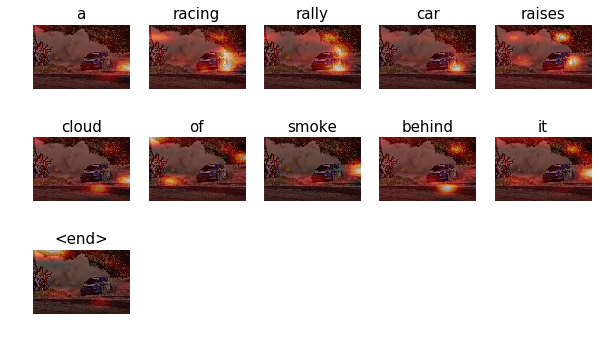

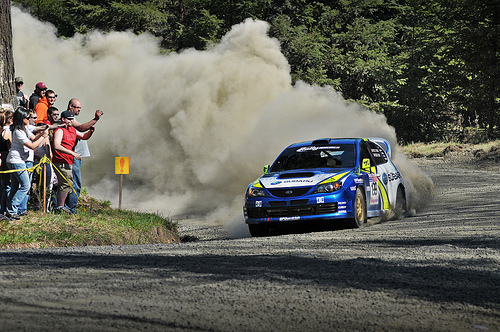

In [142]:
rid = np.random.randint(0, len(test_image))
print(rid)
test_img = test_image[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in test_cap[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_img)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BLEU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_img)


Image.open(test_img)

In [143]:
soundFile = 'pred_caption.mp3'

tts = gTTS(pred_caption, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))